# Analyzing the Social Networks of over 2.7 Billion Reddit Comments


This notebook gives detailed information to help better understand our paper. In this notebook, we will demonstrate how to construct the subreddits' social networks created by more than 2.7 billion comments. Additionally, we will demonstrate how to calculate various statistics related to the subreddits. This code is licensed under a BSD license. See [license file]().

# 0. Setup

Before we begin, make sure you have installed all the required Python packages. (The instructions below use pip. You can use easy_install, too.) Also, consider using virtualenv for a cleaner installation experience instead of sudo. We also recommend running the code via IPython Notebook.
* sudo pip install --upgrade graphlab-create # We mainly used SFrame object, which is an open source package.
* sudo pip install --upgrade praw
* sudo pip install --upgrade seaborn
* sudo pip install --upgrade networkx

# 1. Preparing the Dataset

First, we need to download the compressed Reddit dataset files from [pushshift.io website](http://files.pushshift.io/reddit/comments/). This dataset was created by [Jason Michael Baumgartner](https://twitter.com/jasonbaumgartne). Additional details about this dataset can be found at this [Link](https://www.reddit.com/r/datasets/comments/3bxlg7/i_have_every_publicly_available_reddit_comment/). Downloading this hundreds-of-GB dataset can take a considerable amount of time. To save time, you can download only one month’s, or several months’, worth of data. After we download the dataset, we notice that the dataset is organized in directories, where each directory contains the posts of a specific year. These directories contain posts that were published from December 2005 to the most recent month. For this tutorial, we utilized over 2.71 billion comments that were posted from December 2005 through October 2016. Let's create a single SFrame that contains all these posts. To achieve this, we first will convert each monthly zipped file into an SFrame object using the following code:

In [1]:
import os
import logging
import bz2
from datetime import datetime
import graphlab as gl
import graphlab.aggregate as agg
import fnmatch

gl.canvas.set_target('ipynb')
gl.set_runtime_config('GRAPHLAB_CACHE_FILE_LOCATIONS', '/data/tmp')
gl.set_runtime_config('GRAPHLAB_DEFAULT_NUM_GRAPH_LAMBDA_WORKERS', 128)
gl.set_runtime_config('GRAPHLAB_DEFAULT_NUM_PYLAMBDA_WORKERS', 128)


basedir = "/data/reddit/raw" # Replace this with the directory which you downloaded the file into
sframes_dir = "/data/reddit/sframes/" # Replace this with the directory you want to save the SFrame to
tmp_dir =  "/data/tmp" # Replace this with the directory you want to save the SFrame to

def get_month_from_path(path):
    m = os.path.basename(path)
    m = m.split(".")[0]
    return int(m.split("-")[-1])

def get_year_from_path(path):
    y = os.path.basename(path)
    y = y.split(".")[0]
    return int(y.lower().replace("rc_","").split("-")[0])

def json2sframe(path):
    """
    Creates an SFrame object from the file in the input path
    :param path: path to a file that contains a list of JSON objects, each JSON is saved in a separate line.
        The file can also be compressed in bz2 format.
    :return: SFrame object created from the file in the input path. The SFrame also contains information regarding
     each post date & time
    :rtype: gl.SFrame
    """
    if not path.endswith(".bz2"):
        sf = gl.SFrame.read_json(path, orient="lines")
    else:
        dpath = decompress_bz2(path)
        sf = gl.SFrame.read_json(dpath, orient="lines")
        #remove the decompressed file
        os.remove(dpath)
    #add datetime information
    sf['month'] = get_month_from_path(path)
    sf['year'] = get_year_from_path(path)
    sf['datetime']= sf["created_utc"].apply(lambda utc: datetime.fromtimestamp(float(utc)))

    return sf

def decompress_bz2(inpath, outpath=None):
    """
    Decompress bz2 to the outpath, if the outpath is not provided then decompress the file to the inpath directory
    :param inpath: decompress bz2 file to the outpath
    :param outpath: output path for the decompress file
    :return: the output file path
    """
    if outpath is None:
        outpath = tmp_dir + os.path.sep + os.path.basename(inpath) + ".decompressed"
    out_file = file(outpath, 'wb')
    logging.info("Decompressing file %s to %s" % (inpath,outpath))
    in_file = bz2.BZ2File(inpath, 'rb')
    for data in iter(lambda : in_file.read(100 * 1024), b''):
        out_file.write(data)
    out_file.close()
    in_file.close()
    return outpath

def match_files_in_dir(basedir, ext):
    """
    Find all files in the basedir with 'ext' as filename extension
    :param basedir: input basedir
    :param ext: filename extension
    :return: list of file paths with the input extension
    """
    matches = []
    for root, dirnames, filenames in os.walk(basedir):
        for filename in fnmatch.filter(filenames, ext):
            matches.append(os.path.join(root, filename))
    return matches

#Creating all SFrames
for p in match_files_in_dir(basedir, "*.bz2"):
    logging.info("Analyzing of %s " % p)
    outp = sframes_dir + os.path.sep + os.path.basename(p).replace(".bz2", ".sframe")
    if os.path.isdir(outp): #if file already exists skip it
        logging.info("Skipping the analysis of %s file" % p)
        continue
    sf = json2sframe(p)
    sf.save(outp)

This non-commercial license of GraphLab Create for academic use is assigned .


[INFO] graphlab.cython.cy_server: GraphLab Create v1.10.1 started. Logging: /tmp/graphlab_server_1487345388.log


Finished parsing file /data/tmp/RC_2009-09.bz2.decompressed

Parsing completed. Parsed 100 lines in 1.59448 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 88555 lines. Lines per second: 30815

Read 972023 lines. Lines per second: 112707

Read 1590501 lines. Lines per second: 114090

Finished parsing file /data/tmp/RC_2009-09.bz2.decompressed

Parsing completed. Parsed 2032276 lines in 17.5218 secs.

Finished parsing file /data/tmp/RC_2007-07.bz2.decompressed

Parsing completed. Parsed 100 lines in 0.198544 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 94632 lines. Lines per second: 156665

Finished parsing file /data/tmp/RC_2007-07.bz2.decompressed

Parsing completed. Parsed 203319 lines in 1.03305 secs.

Finished parsing file /data/tmp/RC_2010-04.bz2.decompressed

Parsing completed. Parsed 100 lines in 0.488607 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 92878 lines. Lines per second: 110761

Read 987195 lines. Lines per second: 148575

Read 1706306 lines. Lines per second: 140170

Read 2334976 lines. Lines per second: 134364

Read 2960967 lines. Lines per second: 128167

Finished parsing file /data/tmp/RC_2010-04.bz2.decompressed

Parsing completed. Parsed 3209898 lines in 25.185 secs.

Finished parsing file /data/tmp/RC_2008-02.bz2.decompressed

Parsing completed. Parsed 100 lines in 0.617535 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 90266 lines. Lines per second: 136605

Finished parsing file /data/tmp/RC_2008-02.bz2.decompressed

Parsing completed. Parsed 441768 lines in 2.41619 secs.

Finished parsing file /data/tmp/RC_2013-11.bz2.decompressed

Parsing completed. Parsed 100 lines in 0.398867 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 93427 lines. Lines per second: 116655

Read 1006340 lines. Lines per second: 164450

Read 1743658 lines. Lines per second: 150212

Read 2391411 lines. Lines per second: 143870

Read 3031451 lines. Lines per second: 137447

Read 3594639 lines. Lines per second: 132832

Read 4220255 lines. Lines per second: 128563

Read 4753808 lines. Lines per second: 125179

Read 5301805 lines. Lines per second: 123250

Read 5931101 lines. Lines per second: 121575

Read 6571219 lines. Lines per second: 120869

Read 7197659 lines. Lines per second: 120042

Read 7841761 lines. Lines per second: 119330

Read 8375294 lines. Lines per second: 118202

Read 9026227 lines. Lines per second: 117816

Read 9566787 lines. Lines per second: 117109

Read 10119730 lines. Lines per second: 116743

Read 10671402 lines. Lines per second: 116438

Read 11233997 lines. Lines per second: 115846

Read 11787972 lines. Lines per second: 115434

Read 12353489 lines. Lines per second: 114877

Read 12897495 lines. Lines per second: 114329

Read 13436392 lines. Lines per second: 113802

Read 13988021 lines. Lines per second: 113458

Read 14520339 lines. Lines per second: 113026

Read 15069128 lines. Lines per second: 112649

Read 15609421 lines. Lines per second: 112399

Read 16151055 lines. Lines per second: 112068

Read 16704318 lines. Lines per second: 111809

Read 17241869 lines. Lines per second: 111615

Read 17795142 lines. Lines per second: 111579

Read 18424883 lines. Lines per second: 111525

Read 18975285 lines. Lines per second: 111278

Read 19526267 lines. Lines per second: 111087

Read 20086301 lines. Lines per second: 110780

Read 20639753 lines. Lines per second: 110619

Read 21201167 lines. Lines per second: 110579

Read 21749911 lines. Lines per second: 110421

Read 22283649 lines. Lines per second: 110303

Read 22838839 lines. Lines per second: 110248

Read 23376937 lines. Lines per second: 110130

Read 23917882 lines. Lines per second: 110048

Read 24463955 lines. Lines per second: 109821

Read 24997999 lines. Lines per second: 109753

Read 25640106 lines. Lines per second: 109725

Read 26176052 lines. Lines per second: 109663

Read 26715229 lines. Lines per second: 109540

Read 27268234 lines. Lines per second: 109548

Read 27808660 lines. Lines per second: 109553

Read 28459486 lines. Lines per second: 109741

Read 29016107 lines. Lines per second: 109677

Read 29572557 lines. Lines per second: 109601

Read 30133329 lines. Lines per second: 109591

Read 30692742 lines. Lines per second: 109533

Read 31314738 lines. Lines per second: 109488

Read 31866356 lines. Lines per second: 109523

Read 32403692 lines. Lines per second: 109484

Read 33039587 lines. Lines per second: 109576

Read 33668152 lines. Lines per second: 109537

Read 34306832 lines. Lines per second: 109546

Read 34946529 lines. Lines per second: 109622

Read 35511155 lines. Lines per second: 109566

Read 36056678 lines. Lines per second: 109497

Read 36612604 lines. Lines per second: 109412

Read 37159827 lines. Lines per second: 109401

Finished parsing file /data/tmp/RC_2013-11.bz2.decompressed

Parsing completed. Parsed 37396497 lines in 342.139 secs.

Finished parsing file /data/tmp/RC_2015-04.bz2.decompressed

Parsing completed. Parsed 100 lines in 0.312336 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 87621 lines. Lines per second: 111139

Read 958672 lines. Lines per second: 155552

Read 1655795 lines. Lines per second: 146549

Read 2362006 lines. Lines per second: 139593

Read 2956617 lines. Lines per second: 133005

Read 3554639 lines. Lines per second: 128341

Read 4164682 lines. Lines per second: 124951

Read 4760649 lines. Lines per second: 122688

Read 5272966 lines. Lines per second: 120512

Read 5877312 lines. Lines per second: 118935

Read 6479044 lines. Lines per second: 117519

Read 7005855 lines. Lines per second: 116693

Read 7615144 lines. Lines per second: 115634

Read 8136265 lines. Lines per second: 114780

Read 8750335 lines. Lines per second: 114224

Read 9348939 lines. Lines per second: 113612

Read 9940693 lines. Lines per second: 113174

Read 10544254 lines. Lines per second: 112865

Read 11146698 lines. Lines per second: 112536

Read 11650185 lines. Lines per second: 111939

Read 12241374 lines. Lines per second: 111652

Read 12852366 lines. Lines per second: 111443

Read 13442713 lines. Lines per second: 111099

Read 14030942 lines. Lines per second: 110842

Read 14634795 lines. Lines per second: 110677

Read 15234543 lines. Lines per second: 110483

Read 15822769 lines. Lines per second: 110298

Read 16418992 lines. Lines per second: 110243

Read 16945480 lines. Lines per second: 110102

Read 17537615 lines. Lines per second: 110040

Read 18129754 lines. Lines per second: 109843

Read 18743953 lines. Lines per second: 109789

Read 19260565 lines. Lines per second: 109619

Read 19781895 lines. Lines per second: 109426

Read 20398697 lines. Lines per second: 109443

Read 20999315 lines. Lines per second: 109332

Read 21606085 lines. Lines per second: 109316

Read 22125339 lines. Lines per second: 109170

Read 22716579 lines. Lines per second: 109036

Read 23226544 lines. Lines per second: 108870

Read 23837468 lines. Lines per second: 108834

Read 24430871 lines. Lines per second: 108780

Read 25018270 lines. Lines per second: 108802

Read 25620984 lines. Lines per second: 108784

Read 26220328 lines. Lines per second: 108768

Read 26812801 lines. Lines per second: 108660

Read 27330111 lines. Lines per second: 108603

Read 27946846 lines. Lines per second: 108643

Read 28537022 lines. Lines per second: 108643

Read 48187786 lines. Lines per second: 108075

Read 48777631 lines. Lines per second: 108054

Read 49387231 lines. Lines per second: 108075

Read 49981695 lines. Lines per second: 108058

Read 50569266 lines. Lines per second: 108036

Read 51170286 lines. Lines per second: 108037

Read 51773732 lines. Lines per second: 108010

Read 52366223 lines. Lines per second: 107990

Read 52959875 lines. Lines per second: 107970

Read 53566480 lines. Lines per second: 108004

Read 54156808 lines. Lines per second: 107969

Read 54751484 lines. Lines per second: 107960

Finished parsing file /data/tmp/RC_2015-04.bz2.decompressed

Parsing completed. Parsed 55005780 lines in 509.626 secs.

Finished parsing file /data/tmp/RC_2016-03.bz2.decompressed

Parsing completed. Parsed 100 lines in 0.189317 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 97333 lines. Lines per second: 168845

Read 1080005 lines. Lines per second: 185888

Read 1909710 lines. Lines per second: 172998

Read 2701562 lines. Lines per second: 167108

Read 3467923 lines. Lines per second: 161319

Read 4231987 lines. Lines per second: 157580

Read 5009290 lines. Lines per second: 154457

Read 5769549 lines. Lines per second: 152490

Read 6436298 lines. Lines per second: 150310

Read 7130065 lines. Lines per second: 149038

Read 7796357 lines. Lines per second: 147503

Read 8559683 lines. Lines per second: 146542

Read 9248375 lines. Lines per second: 145701

Read 10032044 lines. Lines per second: 145228

Read 10724434 lines. Lines per second: 144768

Read 11490479 lines. Lines per second: 144395

Read 12255591 lines. Lines per second: 144157

Read 12931788 lines. Lines per second: 143855

Read 13609217 lines. Lines per second: 142995

Read 14358282 lines. Lines per second: 142437

Read 15030833 lines. Lines per second: 142105

Read 15747350 lines. Lines per second: 141460

Read 16513033 lines. Lines per second: 141180

Read 17207458 lines. Lines per second: 141005

Read 17873719 lines. Lines per second: 140663

Read 18637436 lines. Lines per second: 140448

Read 19330691 lines. Lines per second: 140152

Read 20003485 lines. Lines per second: 139969

Read 20672721 lines. Lines per second: 139752

Read 21357763 lines. Lines per second: 139617

Read 22113463 lines. Lines per second: 139393

Read 22782281 lines. Lines per second: 139120

Read 23471168 lines. Lines per second: 139035

Read 24149295 lines. Lines per second: 138944

Read 24829936 lines. Lines per second: 138814

Read 25518255 lines. Lines per second: 138621

Read 26195300 lines. Lines per second: 138538

Read 26981461 lines. Lines per second: 138597

Read 27647834 lines. Lines per second: 138423

Read 28401489 lines. Lines per second: 138375

Read 29085040 lines. Lines per second: 138325

Read 29755782 lines. Lines per second: 138260

Read 30515156 lines. Lines per second: 138098

Read 31211002 lines. Lines per second: 138088

Read 31888427 lines. Lines per second: 137945

Read 32642350 lines. Lines per second: 137896

Read 33323279 lines. Lines per second: 137793

Read 34078348 lines. Lines per second: 137736

Read 34733999 lines. Lines per second: 137665

Read 35516921 lines. Lines per second: 137676

Read 36196952 lines. Lines per second: 137624

Read 36862679 lines. Lines per second: 137525

Read 37552211 lines. Lines per second: 137449

Now let’s join all the SFrame objects into a single object. Please notice that different posts contain different metadata information about each post. Therefore, we will create a single SFrame which contains all the various metadata information.

In [2]:
join_sframe_path = sframes_dir + os.path.sep + "join_all.sframe" # Where to save the join large SFrame object
def get_all_cols_names(sframes_dir):
    """
    Return the column names of all SFrames in the input path
    :param sframes_dir: directory path which contains SFrames
    :return: list of all the column names in all the sframes in the input directory
    :rtype: set()
    """
    sframes_paths = [sframes_dir + os.path.sep + s for s in  os.listdir(sframes_dir)]
    column_names = set()
    for p in sframes_paths:
        if not p.endswith(".sframe"):
            continue
        print p
        sf = gl.load_sframe(p)
        column_names |= set(sf.column_names())
    return column_names

def get_sframe_columns_type_dict(sf):
    """
    Returns a dict with the sframe column names as keys and column types as values
    :param sf: input SFrame
    :return: dict with the sframe column names as keys and column types as values
    :rtype dict[str,str]
    """
    n = sf.column_names()
    t = sf.column_types()

    return {n[i]: t[i]for i in range(len(n))}

def update_sframe_columns_types(sf, col_types):
    """
    Updates the input sframe column types according to the input types dict.
    :param sf: input SFrame object
    :param col_types: dict in which the keys are the column names and the values are the columns types
    :return: SFrame object with column types update to the col_types dict. If a column doesn't exist in the SFrame object
     then a new column is added with None values
    :rtype: gl.SFrame
    """
    sf_cols_dict = get_sframe_columns_type_dict(sf)

    for k,v in col_types.iteritems():
        if k not in sf_cols_dict:
            sf[k] = None
            sf[k] = sf[k].astype(v)
        elif v != sf_cols_dict[k]:
            sf[k] = sf[k].astype(v)
    return sf

def join_all_sframes(sframes_dir, col_types):
    """
    Joins all SFrames in the input directory where the column types are according to col_types dict
    :param sframes_dir:
    :param col_types: dict with column names and their corresponding types
    :return: merged SFrame of all the SFrames in the input directory
    "rtype: gl.SFrame
    """
    sframes_paths = [sframes_dir + os.path.sep + s for s in  os.listdir(sframes_dir) if s.endswith(".sframe")]
    sframes_paths.sort()
    sf = gl.load_sframe(sframes_paths[0])
    sf = update_sframe_columns_types(sf, col_types)
    for p in sframes_paths[1:]:
        if not p.endswith(".sframe"):
            continue
        print "Joining %s" % p
        sf2 = update_sframe_columns_types(gl.load_sframe(p), col_types)
        sf2.__materialize__()
        sf = sf.append(sf2)
        sf.__materialize__()

    return sf



# use the inferred column type according to last month posts' SFrame. Set all other columns to be 
# as type str
#col_names = get_all_cols_names(sframes_dir)
sf = gl.load_sframe(sframes_dir + '/RC_2015-05.sframe')
d = get_sframe_columns_type_dict(sf)
for c in col_names:
    if c not in d:
        print "Found new column %s" %c
    d[c] = str

#Create Single SFrame
sf = join_all_sframes(sframes_dir, d)
sf.save(join_sframe_path)

At the end of this process, we obtained an SFrame with 2,718,784,464 rows, which is about 444 GB in size. Let's use the show function to get a better understanding of the data.


In [3]:
gl.canvas.set_target('ipynb')
sf = gl.load_sframe(join_sframe_path)
#sf.show() # running this can take considerable amount of time

Let's clean it by removing columns that aren't useful for creating the subreddit's social network. Namely, we remove the following columns: "archived," "downs," "retrieved_on," "banned_by," "likes," "user_reports," "saved," "report_reasons," "approved_by," "body_html," "created," "mod_reports," and "num_reports.”


In [4]:
sf = sf.remove_columns(["archived", "downs", "retrieved_on", "banned_by", "likes","user_reports", "saved",
                        "report_reasons", "approved_by", "body_html", "created", "mod_reports", "num_reports"])
sf.__materialize__()

Let's also delete users' posts that are from users that are probably bots and from those who have posted too many messages.

In [5]:
#First let's find how many posts the most active users posted
posts_count_sf = sf.groupby('author', gl.aggregate.COUNT())
posts_count_sf.sort('Count',ascending=False).print_rows(50)

+----------------------+-----------+
|        author        |   Count   |
+----------------------+-----------+
|      [deleted]       | 302138049 |
|    AutoModerator     |  10976942 |
|     conspirobot      |   575576  |
|    ModerationLog     |   562192  |
|     TweetPoster      |   555976  |
|    MTGCardFetcher    |   444411  |
|        RPBot         |   436199  |
|     autowikibot      |   422769  |
|   imgurtranscriber   |   404441  |
|      PoliticBot      |   388444  |
|      dogetipbot      |   374536  |
|   ImagesOfNetwork    |   355037  |
| throwthrowawaytothee |   344583  |
| Late_Night_Grumbler  |   320383  |
|   qkme_transcriber   |   301974  |
| TweetsInCommentsBot  |   282467  |
|    TotesMessenger    |   222073  |
|     Franciscouzo     |   202346  |
|      havoc_bot       |   197761  |
|     morbiusgreen     |   195312  |
|    User_Simulator    |   194358  |
|        Lots42        |   192985  |
|       hit_bot        |   182189  |
|         -rix         |   173022  |
|

To clean the dataset, we removed redditors who posted over 100,000 times and seemed to post automatic content. Additionally, we used the [praw Python package](https://praw.readthedocs.io/en/latest/) to parse the comments posted in the [BotWatchman subreddit](https://www.reddit.com/r/BotWatchman/) in order to identify bots and remove them. We use the following code to assemble a bots list:

In [6]:
import praw


def get_bots_set():
    #Please insert your Reddit application's authentication information.
    #See more details at: https://github.com/reddit/reddit/wiki/OAuth2-Quick-Start-Example#first-steps
    secret ='<insert your secert string>'
    client_id = '<insert your client-id string>'
    user_agent = '<insert your user-agent string>'
    
    reddit = praw.Reddit(client_id=client_id,client_secret=secret, user_agent=user_agent)
    sr = reddit.subreddit('BotWatchman')
    bots_set = set()
    for p in sr.search("overview for", limit=2000):
        bots_set.add(p.title.split(" ")[2])
    return bots_set    


def get_remove_profiles_list(sf):
    # We get the bots set twice to reduce the variance of the results
    bots_set = get_bots_set()
    bots_set |= get_bots_set()
    posts_count_sf = sf.groupby('author', gl.aggregate.COUNT())
    delete_users = set(posts_count_sf[posts_count_sf['Count'] > 100000]['author'])
    delete_users |= bots_set
    return delete_users


delete_users = get_remove_profiles_list(sf)
print "Delete Users List (%s users):\n %s" % (len(delete_users), delete_users)


Delete Users List (951 users):
 set(['Removedpixel', 'SoulFire6464', u'RealtechPostBot', u'serendipitybot', u'r2d8', u'arethemodsasleep', u'squis1000', u'The_Penis_Game_Bot', u'whooshbot', u'Zyra_test', u'hitlerbotv2', u'topredditbot', u'VerseBot', u'MusicB0t', u'Explains_FTFY', u'BaddieBot', u'autourbanbot', 'NinjaDiscoJesus', u'thier_2_their_bot', u'amProbablyPooping', u'Insane_Photo_Bot', u'Auto_Neckbeard_Bot', u'shadowbanbot', u'_Rita_', u'Profanity-bot', u'gracefulclaritybot', u'DataFire_bot', 'autowikibot', u'FTFY_Cat', u'yes_answers.', u'DollarSignDouche', u'ELIMINATE_GIFS', u'PlusOneBot', u'CutoutBot', u'visual_clarification', u'triggeredbot', u'haiku_finder_bot', u'Eats_Small_Text_Bot', u'GameDealsBot', u'Craigslist-Bot', u'STEALTHM0UNTAIN', u'LegoLinkBot', 'atomicimploder', u'Dickish_Bot_Bot', 'BitcoinAllBot', u'/u/codes_comments', u'CuteBot6969', u'LittleHelperRobot', u'Anti-Brigade-Bot3', u'autowikiabot', u'Anti-Brigade-Bot8', 'backpackwayne', u'UnobtaniumTipBot', u'YOGSbot

Next, we used the following code to filter out comments posted by bot redditors that appeared in the bots list.


In [7]:
sf = sf[sf['author'].apply(lambda a: a not in delete_authors)]
len(sf)
sf.save("/data/reddit_data_no_txt_without_bots_and_deleted_authors.sframe")

2389764512

We are left with about 2.39 billion comments.

## 2. Analyzing Subreddits

We want to better understand the structure and evolution of subreddits. Let's calculate some interesting statistics on these subreddit communities. We will start by calculating the number of unique subreddits, and then we’ll create histograms of the number of posts on each subreddit.

In [8]:
#For running this section please make sure you created 'reddit_data_no_txt_without_bots_and_deleted_authors.sframe' as explained
# in the previous section
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import graphlab as gl
import graphlab.aggregate as agg

sns.set(color_codes=True)
sns.set_style("darkgrid")

print "The dataset contains %s unique subreddits." % len(sf['subreddit'].unique())
g = sf.groupby('subreddit', {'posts_num': agg.COUNT()})

The dataset contains 371833 unique subreddits.


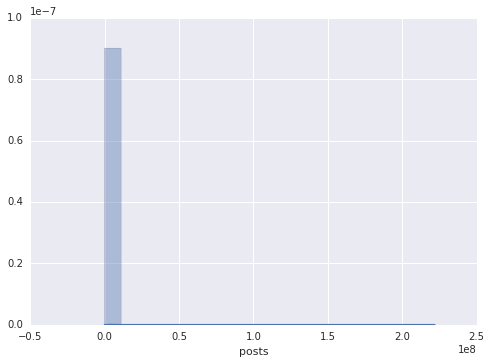

In [9]:
sns.distplot(g['posts_num'],bins=20, axlabel="posts")

We have 371,833 subreddits in the dataset. From the above histogram, we can see that the overwhelming majority of subreddits have very few posts. Let's look at the histogram of subreddits with at least a million posts.

357 subreddits with at least a million posts


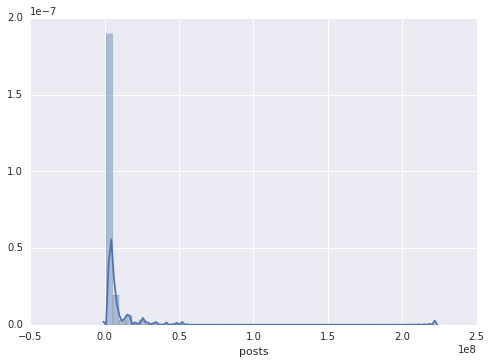

In [10]:
g_mil = g[g['posts_num'] >= 1000000]
print "%s subreddits with at least a million posts" % len(g_mil)
sns.distplot(g_mil['posts_num'], axlabel="posts")

We discover that only 357 subreddits, less 0.1% of all the subreddits, contain more than a million posts. Let's calculate how many posts these subreddits contain in total.

In [11]:
print "The most popular subreddits contain %s posts" % g_mil['posts_num'].sum()

The most popular subreddits contain 1629867408 posts


The most popular subreddits contain over 1.62 billion posts. In other words, less than 0.1% of the subreddits contain 68.2% of the posts. This result reminds me of the fact that over 57% of the world's population lives in the ten most populous [countries](https://en.wikipedia.org/wiki/World_population).
Let's map the users' activity in each subbreddit. Namely, we will find how many distinct user names there are in each subreddit, and what subreddits have the most unique users.

In [12]:
g = sf.groupby('subreddit', {'distinct_authors_number':agg.COUNT_DISTINCT('author')})
g = g.sort('distinct_authors_number', ascending=False)
g.print_rows(100)

+----------------------+-------------------------+
|      subreddit       | distinct_authors_number |
+----------------------+-------------------------+
|      AskReddit       |         5465755         |
|        funny         |         3204002         |
|         pics         |         3076198         |
|         IAmA         |         2155718         |
|        gaming        |         2059042         |
|        videos        |         2021998         |
|         WTF          |         1962940         |
|    todayilearned     |         1902033         |
|    AdviceAnimals     |         1679658         |
|         aww          |         1525875         |
|      worldnews       |         1503139         |
|        movies        |         1341623         |
|         gifs         |         1327207         |
|        Music         |         1265940         |
|         news         |         1120131         |
|       politics       |         1078397         |
|   leagueoflegends    |       

By calculating the elapsed time between users' first post and last post, we can also estimate how much time users have been active in each subreddit.

In [13]:
Important: running the following code block may take considerable time
sf['created_utc'] = sf['created_utc'].astype(int)
subreddit_users = sf.groupby(['subreddit', 'author'], {'start_date':agg.MIN('created_utc'), 'end_date': agg.MAX('created_utc'), 'posts_num':agg.COUNT()} )
subreddit_users['activity_time'] = subreddit_users.apply(lambda d: d['end_date'] - d['start_date'])
subreddit_users

Columns:
	author	str
	subreddit	str
	start_date	int
	end_date	int
	posts_num	int
	activity_time	int

Rows: 170259623

Data:
+--------------------+-------------------+------------+------------+-----------+
|       author       |     subreddit     | start_date |  end_date  | posts_num |
+--------------------+-------------------+------------+------------+-----------+
|      d4mini0n      |       ainbow      | 1334038071 | 1427931191 |     9     |
|    polinreddit     |        news       | 1325830586 | 1325830586 |     1     |
|  goliveyourdreams  |   relationships   | 1337470570 | 1451506045 |     27    |
|       ssa111       |     spreading     | 1448388980 | 1451500948 |     2     |
|     SugarBeets     |  malelivingspace  | 1356540644 | 1474085882 |     20    |
|       Wejurt       |      canucks      | 1429683528 | 1430083478 |     8     |
|   themonthofmae    |   relationships   | 1468165432 | 1468165480 |     2     |
|     Puckhead7      | ColoradoAvalanche | 1419580278 | 1476590616 |     43    |
| throwitawaytrustme |   relationships   | 1448225775 | 1448225775 |     1     |
|   spinstartshere   |       Lenovo      | 1455307194 | 1456503969 |     3     |
+--------------------+-------------------+------------+------------+-----------+
+---------------+
| activity_time |
+---------------+
|    93893120   |
|       0       |
|   114035475   |
|    3111968    |
|   117545238   |
|     399950    |
|       48      |
|    57010338   |
|       0       |
|    1196775    |
+---------------+
[170259623 rows x 6 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

Let's calculate the average time users have been active in each subreddit. To understand the activity time distribution across the subreddits, let's plot a histogram of average activity time.

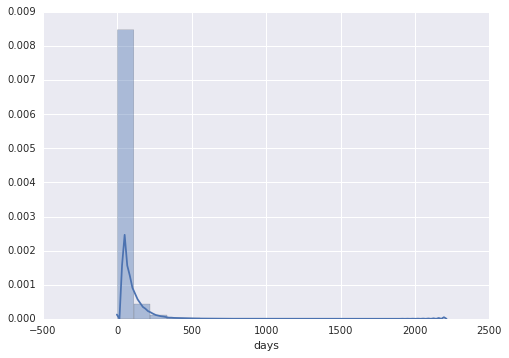

In [14]:
g = subreddit_users.groupby('subreddit', {'avg_active_time_in_seconds': agg.AVG('activity_time')})
g['avg_active_time_in_days'] = g['avg_active_time_in_seconds'].apply(lambda sec: sec/(60.0*60.0*24))
sns.distplot(g['avg_active_time_in_days'], axlabel="days", bins=20 )

In [15]:
g['avg_active_time_in_days'].sketch_summary()


+--------------------+---------------+----------+
|        item        |     value     | is exact |
+--------------------+---------------+----------+
|       Length       |     371833    |   Yes    |
|        Min         |      0.0      |   Yes    |
|        Max         | 2208.85173611 |   Yes    |
|        Mean        | 24.0121476349 |   Yes    |
|        Sum         | 8928508.89152 |   Yes    |
|      Variance      | 3906.78028205 |   Yes    |
| Standard Deviation | 62.5042421124 |   Yes    |
|  # Missing Values  |       0       |   Yes    |
|  # unique values   |     201266    |    No    |
+--------------------+---------------+----------+

Most frequent items:
+-------+--------+-------------------+-------------------+-------------------+
| value |  0.0   | 2.31481481481e-05 | 6.94444444444e-05 | 1.15740740741e-05 |
+-------+--------+-------------------+-------------------+-------------------+
| count | 154663 |        383        |        381        |        372        |
+-------+--

We can see from the above results that most of the subreddits' users are active for a very limited time, with an average of less than a month and a median of less than a day.

## 3. Join-Rate Curves

In our [study](http://dynamics.cs.washington.edu/publications.html), we focused on analyzing the various patterns in which users join each subreddit (also referred to as the Join-Rate-Curve). In this section, we present the code that was used to create these curves. To create the join-rate-curve of each subreddit, we first created a TimeSeries object with the subreddit information. Throughout this section, we will use the [_Science_ subreddit](https://www.reddit.com/r/science/)  as an example.


In [16]:
from datetime import datetime, timedelta

science_sf = sf[sf['subreddit'] =='science']
science_sf['datetime'] = science_sf['created_utc'].apply(lambda utc:datetime.utcfromtimestamp(int(utc)))
subreddit_ts = gl.TimeSeries(science_sf, index='datetime')
subreddit_ts

Columns:
	datetime	datetime (index column)
	author	str
	author_flair_css_class	str
	author_flair_text	str
	body	str
	controversiality	str
	created_utc	str
	distinguished	str
	edited	str
	gilded	str
	id	str
	link_id	str
	parent_id	str
	retrieved_on	str
	score	str
	stickied	str
	subreddit	str
	subreddit_id	str
	ups	str
	month	str
	year	str
	banned_by	str
	replies	str
	removal_reason	str
	likes	str
	user_reports	str
	saved	str
	archived	str
	report_reasons	str
	approved_by	str
	downs	str
	body_html	str
	score_hidden	str
	name	str
	created	str
	mod_reports	str
	num_reports	str

Rows: 4975855

Data:
+---------------------+----------------+------------------------+
|       datetime      |     author     | author_flair_css_class |
+---------------------+----------------+------------------------+
| 2006-10-18 16:36:27 |   conrad_hex   |          null          |
| 2006-10-18 16:56:54 |  the_seanald   |          null          |
| 2006-10-18 17:07:48 | Mr_Smartypants |          null          |
| 2006-10-18 17:10:15 |     tcervl     |          null          |
| 2006-10-18 17:18:07 |  Lagged2Death  |          null          |
| 2006-10-18 18:37:48 |   anonymgrl    |          null          |
| 2006-10-18 19:13:51 |   Saintstace   |          null          |
| 2006-10-18 19:30:02 |    _jjsonp     |          null          |
| 2006-10-18 20:46:34 |    dsandler    |          null          |
| 2006-10-18 21:09:39 |   NitsujTPU    |        compsci         |
+---------------------+----------------+------------------------+
+------------------------+-------------------------------+------------------+
|   author_flair_text    |              body             | controversiality |
+------------------------+-------------------------------+------------------+
|          null          | It sort of sounds like the... |        0         |
|          null          | The 10 year old inside me ... |        0         |
|          null          | One would think a journali... |        0         |
|          null          | almost useful!\r\n\r\nFor ... |        0         |
|          null          | An entertaining rant. Defi... |        0         |
|          null          |               :)              |        1         |
|          null          | No, but you just gave me t... |        0         |
|          null          | that is fascinating. i won... |        0         |
|          null          | Or, at least, bolder, whic... |        0         |
| PhD | Computer Science | Mind Hacks is awesome.  Th... |        0         |
+------------------------+-------------------------------+------------------+
+-------------+---------------+--------+--------+-------+---------+-----------+
| created_utc | distinguished | edited | gilded |   id  | link_id | parent_id |
+-------------+---------------+--------+--------+-------+---------+-----------+
|  1161189387 |      null     | false  |   0    | cmqc1 | t3_mpuf |  t3_mpuf  |
|  1161190614 |      null     | false  |   0    | cmqf7 | t3_mp5w |  t3_mp5w  |
|  1161191268 |      null     | false  |   0    | cmqha | t3_mpuf |  t3_mpuf  |
|  1161191415 |      null     | false  |   0    | cmqhk | t3_mppf |  t3_mppf  |
|  1161191887 |      null     | false  |   0    | cmqiv | t3_mpjm |  t3_mpjm  |
|  1161196668 |      null     | false  |   0    | cmqyw | t3_mp5w |  t1_cmqf7 |
|  1161198831 |      null     | false  |   0    | cmr6f | t3_mr3t |  t3_mr3t  |
|  1161199802 |      null     | false  |   0    | cmrbo | t3_mp5w |  t3_mp5w  |
|  1161204394 |      null     | false  |   0    | cmrsx | t3_mpuf |  t1_cmqc1 |
|  1161205779 |      null     | false  |   0    | cmrxx | t3_mqcp |  t3_mqcp  |
+-------------+---------------+--------+--------+-------+---------+-----------+
+--------------+-------+----------+-----------+--------------+-----+-------+-----+
| retrieved_on | score | stickied | subreddit | subreddit_id | ups | month | ... |
+--------------+-------+----------+-----------+--------------+-----+-------+-----+
|  1473802574

We will use the following function to create the subreddit user arrival curve from the TimeSeries object.

In [17]:
import math
def get_subreddit_users_arrival_curve(subreddit_ts, weeks_number=4):
    """
    Calculates the percent of authors that joined after X weeks from all authors that joined the subreddit
    between the date of the first comment and the date of the last comment
    :param subreddit_ts: TimeSeries with the subreddit posts information
    :param weeks_number: the number of weeks to set the time-interval between each two calculations
    :return: dict in which all the keys are the number of weeks since the first comment was posted and the
        corresponding percentage of authors that joined the subreddit up until this week
    :rtype: dict
    """
    dt = subreddit_ts.min_time
    end_dt = subreddit_ts.max_time
    authors = set()
    d = {0: 0}
    td = timedelta(days=7 * weeks_number)
    count = 1
    total_authors_num = float(len(subreddit_ts['author'].unique()))    
    while dt + td <= end_dt:
        ts = subreddit_ts.slice(dt, dt + td)
        authors |= set(ts['author'])
        print "Calculating the user arrival curve between %s and %s" % (dt, dt + td) 
        dt += td
        d[count * weeks_number] = len(authors) / total_authors_num
        count += 1
    ts = subreddit_ts.slice(dt, subreddit_ts.max_time)
    authors |= set(ts['author'])
    subreddit_age = subreddit_ts.max_time - subreddit_ts.min_time
    d[math.ceil(     subreddit_age.days/ 7.0)] = len(
        authors) / total_authors_num  # round the number of weeks up mainly for drawing the graph
    return d
d = get_subreddit_users_arrival_curve(subreddit_ts)

Calculating the user arrival curve between 2006-10-18 16:36:27 and 2006-11-15 16:36:27
Calculating the user arrival curve between 2006-11-15 16:36:27 and 2006-12-13 16:36:27
Calculating the user arrival curve between 2006-12-13 16:36:27 and 2007-01-10 16:36:27
Calculating the user arrival curve between 2007-01-10 16:36:27 and 2007-02-07 16:36:27
Calculating the user arrival curve between 2007-02-07 16:36:27 and 2007-03-07 16:36:27
Calculating the user arrival curve between 2007-03-07 16:36:27 and 2007-04-04 16:36:27
Calculating the user arrival curve between 2007-04-04 16:36:27 and 2007-05-02 16:36:27
Calculating the user arrival curve between 2007-05-02 16:36:27 and 2007-05-30 16:36:27
Calculating the user arrival curve between 2007-05-30 16:36:27 and 2007-06-27 16:36:27
Calculating the user arrival curve between 2007-06-27 16:36:27 and 2007-07-25 16:36:27
Calculating the user arrival curve between 2007-07-25 16:36:27 and 2007-08-22 16:36:27
Calculating the user arrival curve between 

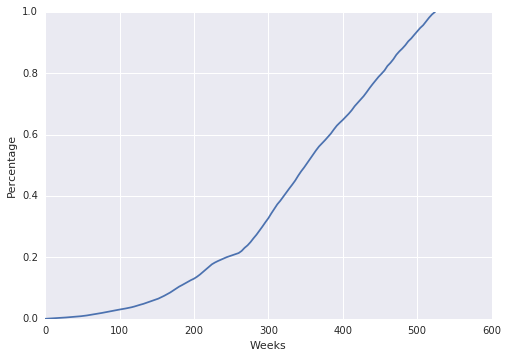

In [18]:
keys = d.keys()
keys.sort()
values = [d[k] for k in keys]
plt.plot(keys, values)
plt.xlabel('Weeks')
plt.ylabel('Percentage')

## 4. Creating the Subreddit Social Network

In our study, we constructed the subreddit social networks by creating links between users that replied to other users’ posts. In this section, we will present the code which was used to create the subreddits' underlying social networks. As an example, we will use the [Datasets subreddit's](https://www.reddit.com/r/datasets/) social network.

In [19]:
def get_subreddit_vertices_timeseries(subreddit_sf):
    """
    Creates a vertices Timeseries object
    :return: TimeSeries with the join time of each user to each subreddit
     :rtype: gl.TimeSeries
    """
    sf =  subreddit_sf.groupby("author", {'mindate': agg.MIN("created_utc"),
                                         'maxdate': agg.MAX("created_utc")})
    sf['mindate'] = sf['mindate'].apply(lambda timestamp: datetime.fromtimestamp(timestamp))
    sf['maxdate'] = sf['maxdate'].apply(lambda timestamp: datetime.fromtimestamp(timestamp))
    sf.rename({"author": "v_id"})
    return gl.TimeSeries(sf, index='mindate')


def get_subreddit_interactions_timeseries(subreddit_sf):
    """
    Creates subreddits interactions TimeSeries. Interaction exists between two subreddit users if user A posted a comment
     and user B replied to A's comment
    :return: TimeSeries with the subreddit interactions
    :rtype: gl.TimeSeries
    """
    subreddit_sf['parent_name'] = subreddit_sf["parent_id"]
    subreddit_sf['parent_kind'] = subreddit_sf['parent_id'].apply(lambda i: i.split("_")[0] if "_" in i and i.startswith("t") else None)
    subreddit_sf['parent_id'] = subreddit_sf['parent_id'].apply(lambda i: i.split("_")[1] if "_" in i and i.startswith("t") else None)

    sf = subreddit_sf[subreddit_sf['parent_kind'] == 't1'] # only reply to comments counts
    sf = sf['author', "created_utc", "id", "parent_id", "link_id"]
    sf = sf.join(subreddit_sf, on={"parent_id": "id"})
    sf['datetime'] = sf['created_utc'].apply(lambda timestamp: datetime.fromtimestamp(timestamp))
    sf.rename({'author': 'src_id', 'author.1': 'dst_id'})
    sf = sf['src_id', 'dst_id', 'datetime']
    return gl.TimeSeries(sf, index='datetime')

def create_sgraph(v_ts, i_ts):
    """
    Creates an SGraph object from the vertices and interaction TimeSeries objects
    :param v_ts: vertices TimeSeries
    :param i_ts: interactions TimeSeries
    :return: SGraph with the input data
    """
    edges = i_ts.to_sframe().groupby(['src_id', "dst_id"], operations={'weight': agg.COUNT(),
                                                                     'mindate': agg.MIN('datetime'),
                                                                     'maxdate': agg.MAX('datetime')})

    g = gl.SGraph(vertices=v_ts.to_sframe(), edges=edges, vid_field="v_id", src_field="src_id", dst_field="dst_id")
    return g


datasets_sf = sf[sf['subreddit'] =='datasets']
datasets_sf.__materialize__()
datasets_sf["created_utc"] = datasets_sf["created_utc"].astype(int)
vertices = get_subreddit_vertices_timeseries(datasets_sf)
interactions = get_subreddit_interactions_timeseries(datasets_sf)
vertices.print_rows(10)
interactions.print_rows(10)
g = create_sgraph(vertices,interactions)

+---------------------+----------------+---------------------+
|       mindate       |      v_id      |       maxdate       |
+---------------------+----------------+---------------------+
| 2010-04-05 08:18:54 |    voltagex    | 2015-09-27 04:06:28 |
| 2010-04-05 08:50:31 |      qwak      | 2010-04-09 08:37:35 |
| 2010-04-05 14:13:55 |      brey      | 2010-04-05 14:13:55 |
| 2010-04-05 14:44:42 | actionscripted | 2013-12-01 06:50:26 |
| 2010-04-05 15:00:51 |     bcain      | 2012-11-14 17:57:45 |
| 2010-04-05 15:57:46 |    reconbot    | 2010-04-05 15:57:46 |
| 2010-04-05 19:26:25 |      jc4p      | 2010-04-06 01:05:28 |
| 2010-04-05 22:27:12 |    Orborde     | 2010-04-05 22:27:12 |
| 2010-04-05 23:57:52 |     dmwit      | 2010-04-05 23:57:52 |
| 2010-04-06 00:11:33 |   alphabeat    | 2011-09-15 02:22:17 |
+---------------------+----------------+---------------------+
[4047 rows x 3 columns]

+---------------------+----------+----------+
|       datetime      |  src_id  |  dst_id  |
+

We created an [SGraph object](https://turi.com/products/create/docs/generated/graphlab.SGraph.html) from the SFrame. Let's visualize the constructed social network.

In [20]:
g.summary()

{'num_edges': 3935, 'num_vertices': 4047}

In [21]:
import os
import logging
import bz2
from datetime import datetime
import graphlab as gl
import graphlab.aggregate as agg
import fnmatch

#gl.canvas.set_target('ipynb')
gl.set_runtime_config('GRAPHLAB_CACHE_FILE_LOCATIONS', '/data/tmp')
gl.set_runtime_config('GRAPHLAB_DEFAULT_NUM_GRAPH_LAMBDA_WORKERS', 128)
gl.set_runtime_config('GRAPHLAB_DEFAULT_NUM_PYLAMBDA_WORKERS', 128)


basedir = "/data/reddit/raw" # Replace this with the directory which you downloaded the file into
sframes_dir = "/data/reddit/sframes/" # Replace this with the directory you want to save the SFrame to
tmp_dir =  "/data/tmp" # Replace this with the directory you want to save the SFrame to
join_sframe_path = sframes_dir + os.path.sep + "join_all.sframe" # Where to save the join large SFrame object
sf = gl.load_sframe("/data/reddit_data_no_txt_without_bots_and_deleted_authors.sframe")
subreddit_users = gl.load_sframe("/data/subreddits_users.sframe")

This non-commercial license of GraphLab Create for academic use is assigned.


[INFO] graphlab.cython.cy_server: GraphLab Create v1.10.1 started. Logging: /tmp/graphlab_server_1487650195.log


We can use GraphLab's [analytics toolkit](https://turi.com/products/create/docs/graphlab.toolkits.graph_analytics.html) to calculate various topological properties, such as the degree distribution and the graph's number of triangles. We hope to elaborate on this in a future tutorial. For now, let's use [Networkx package](https://networkx.github.io/) to draw this subreddit's social network.

In [22]:
import networkx as nx
def sgraph2nxgraph(sgraph):
    """ Converts a directed sgraph object into networkx object
    :param sgraph: GraphLab SGraph object
    :return: Networkx Directed Graph object
    """
    nx_g = nx.DiGraph()
    vertices = list(sgraph.get_vertices()['__id'])
    edges = [(e['__src_id'], e['__dst_id']) for e in sgraph.get_edges()]
    nx_g.add_nodes_from(vertices)
    nx_g.add_edges_from(edges)
    return nx_g
nx_g = sgraph2nxgraph(g)

Let's draw a subgraph of the subreddit                

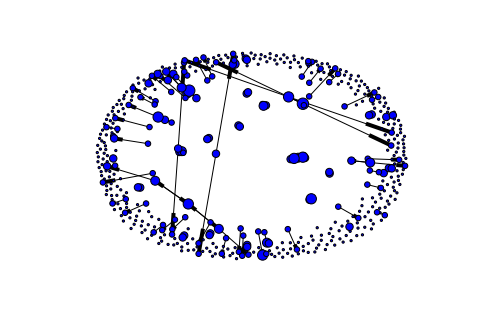

In [23]:
import networkx as nx
import random
def draw_graph(g,layout_func=nx.spring_layout):
    pos = layout_func(g)
    d = nx.degree(g)
    n_sizes = [v * 25 +5 for v in d.values()]
    nx.draw(g, nodelist=d.keys(), node_size=n_sizes, node_color='blue')

# Selecting only sample of vertices with degree greater than 0
d = nx.degree(nx_g)    
v_list = [v for v in d.keys() if d[v] >0]
h = nx_g.subgraph(v_list[:500])
draw_graph(h)

## 5. Where to Go from Here

The social network dataset created as a result of our study opens the door for new and exciting research opportunities. This dataset can help not only to better understand the social structure of the Reddit community in particular, but also to understand how social networks and online communities evolve over time. Moreover, this corpus can be used as a ground-truth dataset for many studies in the field of social networks. Some examples of what can be done with this corpus are:
* Understanding topological factors that may help a post to go viral.
* Helping to better understand diffusion models and also assisting in validating diffusion models using real-world data.
* Using this dataset as an excellent ground-truth dataset for evaluating entity-matching algorithms, based on our observation that many redditors are members in several subreddits.
* Helping understand the connection between content and social networks; for instance, this dataset can provide insight on what type of content makes users more likely to interact with each other.

We would love to hear other ideas on what possible work can be done with our provided datasets.

## 6. Further Reading

Further reading material:
* [I have every publicly available Reddit comment for research ~ 1.7 billion comments @ 250 GB compressed. Any interest in this?](https://www.reddit.com/r/datasets/comments/3bxlg7/i_have_every_publicly_available_reddit_comment/)
* [Navigating the massive world of Reddit: using backbone networks to map user interests in social media](https://peerj.com/articles/cs-4/)
* [Don't feed the troll: Shutting down debate about community expectations on Reddit.com](http://firstmonday.org/ojs/index.php/fm/article/viewArticle/3498/3029)
* [GraphLab Create User Guide](https://turi.com/learn/userguide/)